In [1]:
import pandas as pd
from fbprophet import Prophet

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Généralités sur les time series

## Analyse de séries temporelles



1.  Chargement
2.  Prétraitements
3.  Modèles descriptifs
                
        Les modèles descriptifs sont des éléments considérés pour comprendre comment un système fonctionne. Ils permettent notamment de quantifier les relations entre les données.
        Rendre compte d’une masse d’informations de manière à pouvoir établir une interprétation. 

4.  Modèles prédictifs

        Les modèles prédictifs sont axés sur la prédiction d’un seul comportement 


## Définition



Données avec une indexation temporelle

(peut être générées à partir de n'importe quelles données ayant au moins un attribut chronologique)



## Séries temporelles régulières ou irrégulières



régulières → [fréquence d'échantillonnage](https://pandas.pydata.org/docs/reference/api/pandas.Series.asfreq.html)



## Autocorrélation



Relation linéaire entre le passé (immédiat) et le présent.
(~ régressionlinéaire sur une *fenêtre glissante*)



## Extrapolation vs Interpolation



-   Il est beaucoup plus difficilede prédire le futur que le passé !
    -   le découpage apprentissage / validation / test doit être chronologique
-   surtout le futur éloigné :
    -   (N pas plus loin vs 1 pas plus loin)
    
    ==> L'horizon (h)


nb : L'extrapolation est un calcul qui consiste également à estimer la valeur inconnue d'une des deux variables étudiées. Contrairement à l'interpolation, ce calcul est réalisé en dehors du domaine d'étude fourni par l'échantillon en utilisant le modèle mathématique obtenu.


## Valeurs manquantes



Compte-tenu de l'auto-corrélation et de la nécessité d'avoir des
   séries temporelles régulières pour la plupart des algorithmes, il
   est souvent pertinent de faire de l'interpolation ou du *forward
   fill* pour remplacer les valeurs manquantes.



## Les dates ne sont pas simples



-   fuseaux horaires
-   années bissextiles
-   heure d'été / d'hiver


## Attributs chronologiques



Enrichissement des données :

-   générique (e.g. jour de la semaine)
-   spécifique (e.g. vacances)



## Prévisibilité ?



# Exemple sur une série temporelle

## Exploration

#### Charger le dataset "rte.csv" 

nb : Time index etc ...

In [ ]:
# TBD

df = pd.read_csv('rte.csv', index_col = 'ds', parse_dates = ['ds'])
df.head()

,y
ds,
2014-11-29 23:00:00,55430
2014-11-29 23:30:00,52613
2014-11-30 00:00:00,52039
2014-11-30 00:30:00,51257
2014-11-30 01:00:00,50614


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2014-11-29 23:00:00 to 2014-11-01 22:30:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       1440 non-null   int64
dtypes: int64(1)
memory usage: 22.5 KB


## Echantillonnage

==> Observation des profils de serie



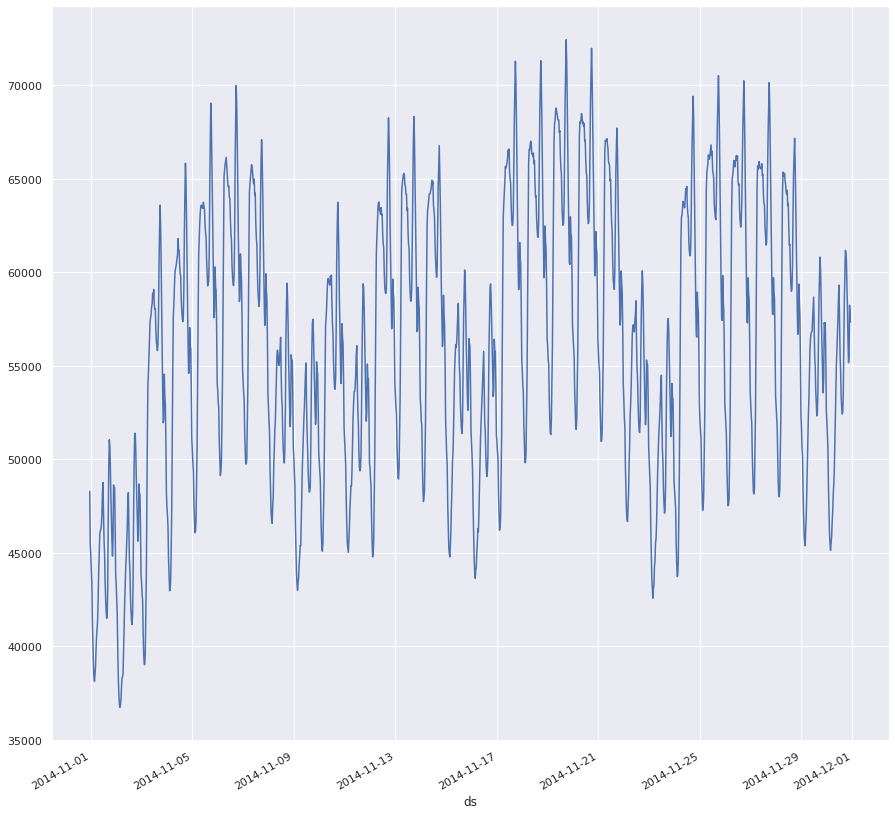

In [ ]:
# TBD
df['y'].plot()


#### Réechantillonnez par jours  et visualisez

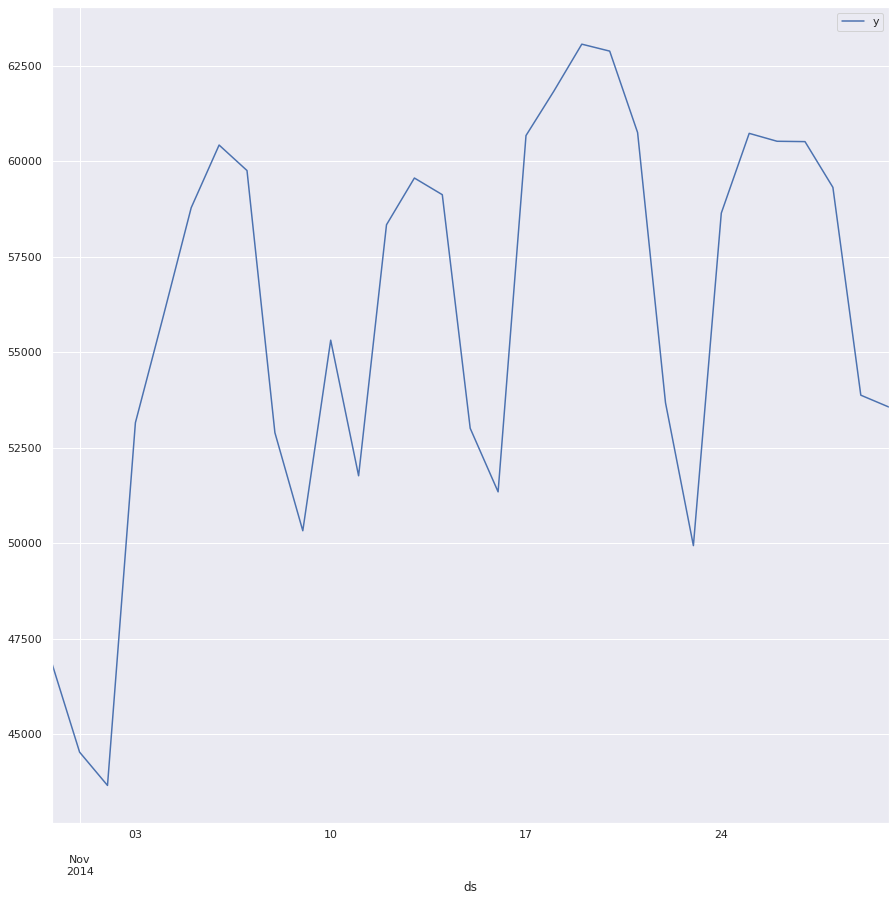

In [ ]:
df.loc['01-11-2014':'30-11-2014'].resample('d').mean().plot()

### Passage en analyse journaliere 

Superposer le tracé de la serie selon differents echantillonage, permet de se confronter à des paradoxes

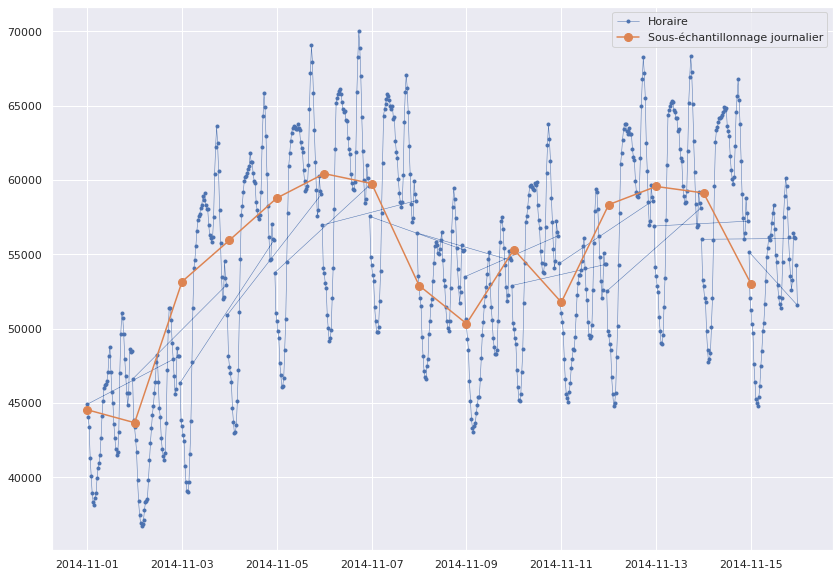

In [ ]:
import matplotlib.pyplot as plt
start, end = '2014-11-01', '2014-11-15'
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(df.loc[start:end, 'y'], marker='.', linestyle='-', linewidth=0.5, label='Horaire')
ax.plot(df.resample('D').mean().loc[start:end, 'y'], marker='o', markersize=8, linestyle='-', label='Sous-échantillonnage journalier')
ax.legend();

## Tendance

==> Une moyenne mobile calculée sur plusieurs pas de temps a tendance à detruire les periodicités et valoriser la tendance

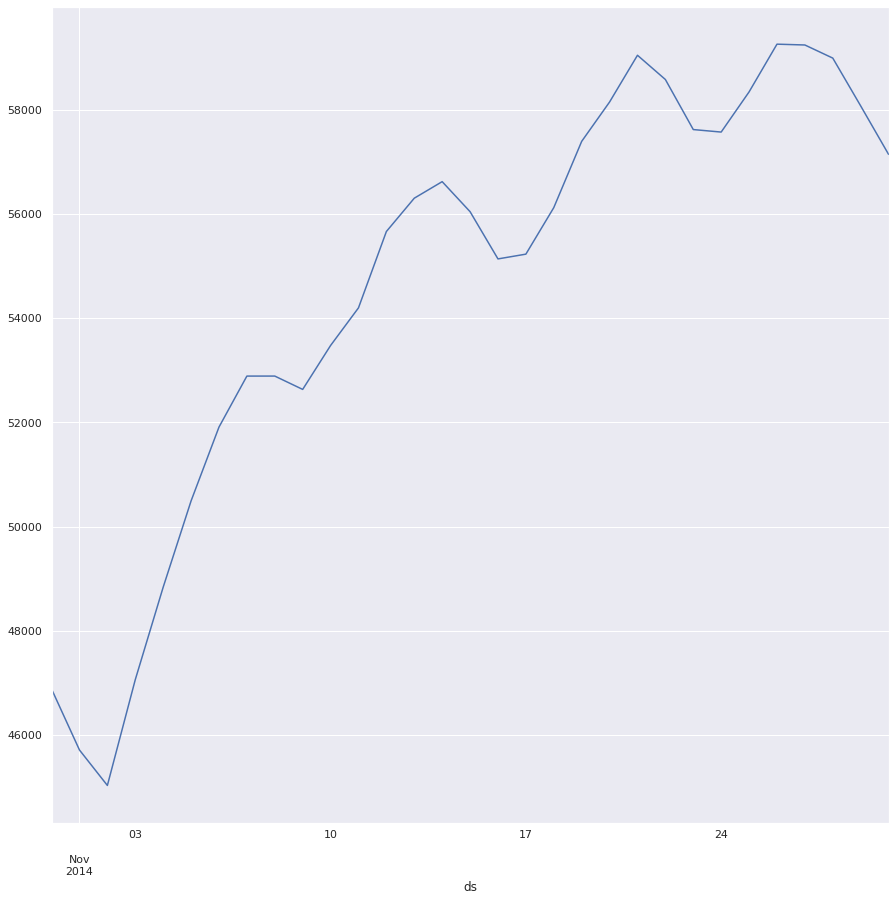

In [ ]:
df['y'].resample('d').mean().rolling('10D').mean().plot()

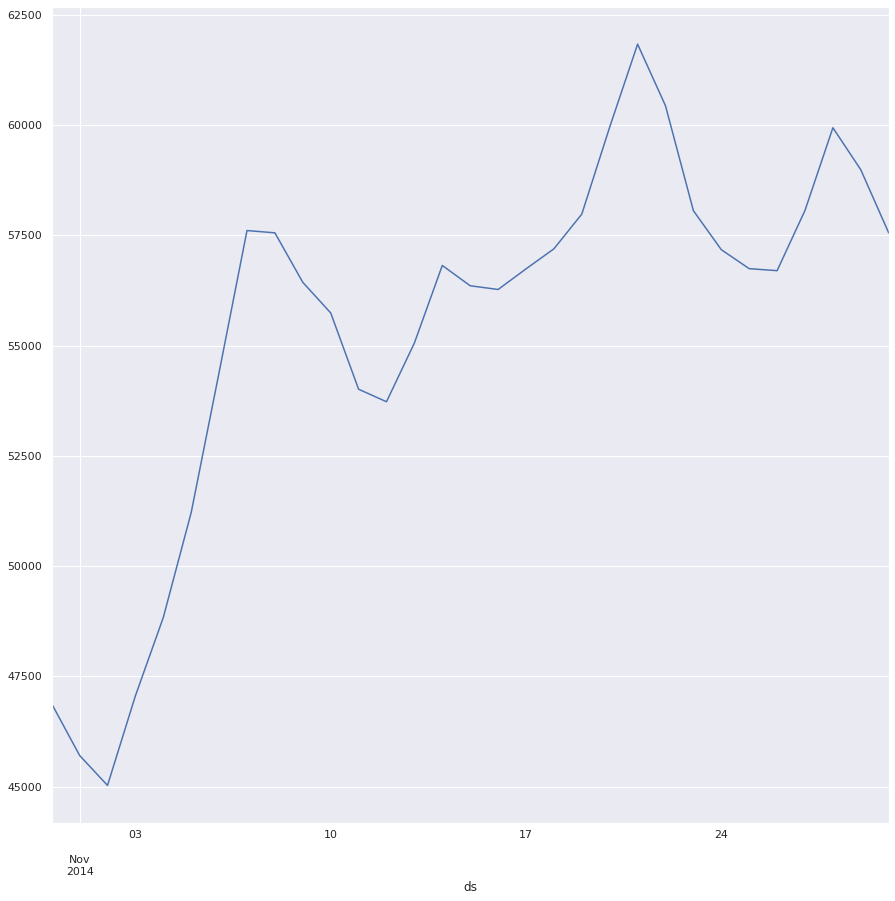

In [ ]:
 jour = df['y'].resample('d').mean()
jour.rolling('5D').mean().plot()

## Composantes temporelles

#### Creer un colonne "day_of_week", "day_name", "hour"

In [ ]:
# TBD
df['day_of_week']= df.index.weekday
df['day_name']= df.index.day_name()
df['hour']= df.index.hour
df.head()


,y,day_of_week,day_name,hour
ds,,,,
2014-11-29 23:00:00,55430,5,Saturday,23
2014-11-29 23:30:00,52613,5,Saturday,23
2014-11-30 00:00:00,52039,6,Sunday,0
2014-11-30 00:30:00,51257,6,Sunday,0
2014-11-30 01:00:00,50614,6,Sunday,1


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


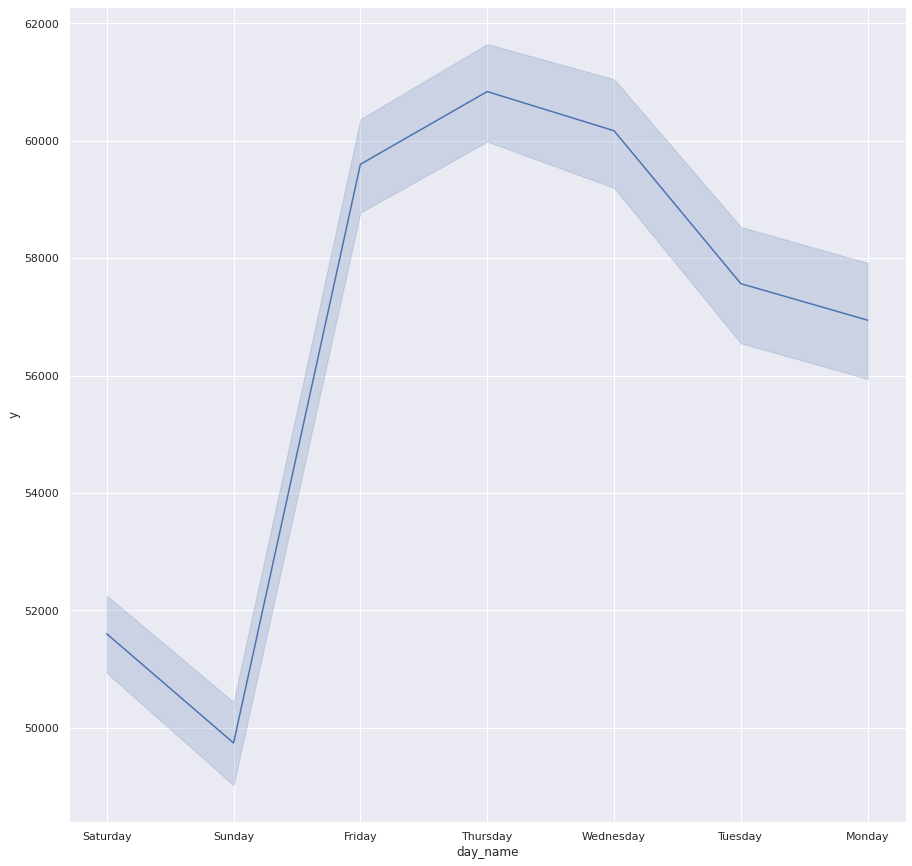

In [ ]:
import seaborn as sns
ax =sns.lineplot(x= 'day_name', y= 'y', data= df)

#### Realiser une viz (violon) permettant d'observer la distribution des valeurs par jours de la semaine

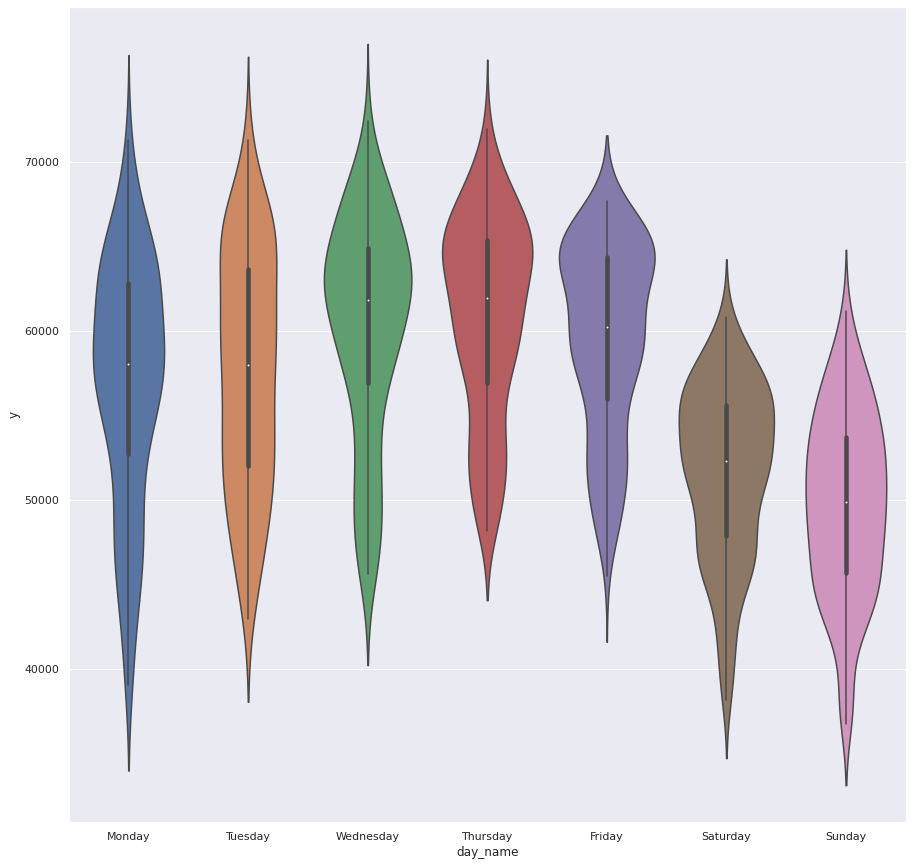

In [ ]:
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,15)})
sns.violinplot(x = 'day_name', y = "y", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"],data = df)

# TBD

## Prophet (facebook)
Ce qu'on voudrait, c'est pourvoir modéliser à la fois :

-   une tendance long terme, mais éventuellement avec des ruptures
-   plusieurs tendances cycliques
-   des évènements particuliers

On peut utiliser pour cela des [modèles additifs géneralisés](https://fr.wikipedia.org/wiki/Mod%C3%A8le_additif_g%C3%A9n%C3%A9ralis%C3%A9)
(Generalized Additive Model) et la [bibliothèque prophet](https://peerj.com/preprints/3190.pdf), [implémente ce type de modèle](https://medium.com/future-vision/the-math-of-prophet-46864fa9c55a).



Un modèle de décomposition consiste à appliquer des transformations pour simplifier sa série temporelle. C’est une méthode très efficace et très générale, son application est omniprésente en analyse des séries temporelles, avec différentes variations.


In [ ]:
df = pd.read_csv('rte.csv')
df.head()

,ds,y
0,2014-11-29 23:00:00,55430
1,2014-11-29 23:30:00,52613
2,2014-11-30 00:00:00,52039
3,2014-11-30 00:30:00,51257
4,2014-11-30 01:00:00,50614


### Model

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

m = Prophet(yearly_seasonality="auto",
    weekly_seasonality='auto',
    daily_seasonality='auto')
m.fit(df,verbose=False)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


### Predictions

In [ ]:
future = m.make_future_dataframe(periods=30)
future.tail()

,ds
1465,2014-12-26 22:30:00
1466,2014-12-27 22:30:00
1467,2014-12-28 22:30:00
1468,2014-12-29 22:30:00
1469,2014-12-30 22:30:00


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1465,2014-12-26 22:30:00,62289.656501,19218.751114,105264.434235
1466,2014-12-27 22:30:00,55811.032626,10256.149298,101724.941544
1467,2014-12-28 22:30:00,60008.069054,12211.489981,109305.000472
1468,2014-12-29 22:30:00,65319.914911,14900.573389,116960.346933
1469,2014-12-30 22:30:00,65343.170542,13249.838379,119543.674886


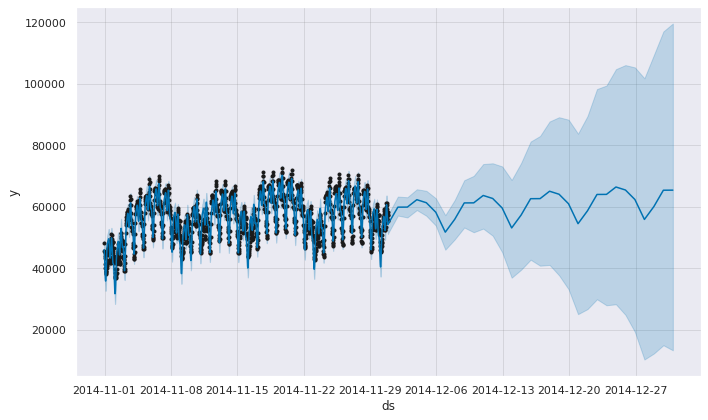

In [ ]:
_ = m.plot(forecast)

### Composantes

Evolution des composantes de tendance, cycle hebdomadaire et journalier parametrés par Prophet

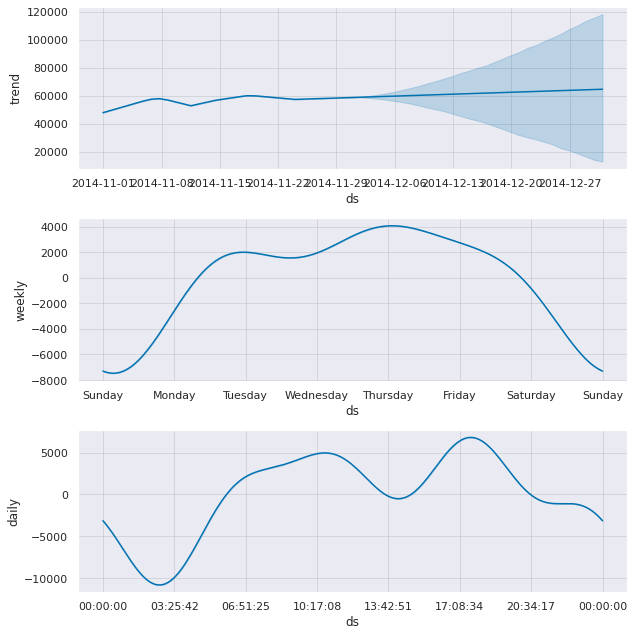

In [ ]:
_ = m.plot_components(forecast)

#### Utiliser le dataset de votre projet (Controle continue) et realiser une projection dans le futur avec prophet ?